<table>
<tr>    
<td style="text-align: center">
<h1>Wprowadzenie do optymalizacji, regularyzacji, generalizacji<br />oraz radzenie sobie z niedopasowaniem i nadmiernym<br /> dopasowaniem modeli sieci neuronowych</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index.php">Adrian Horzyk</a></h2>
</td> 
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk49BT140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
</tr>
</table>
<h3><i>Zapraszam do interaktywnego notebooka, w którym możesz dowiedzieć się, jak działają sieci neuronowe, doświadczysz i sprawdzisz ich działanie na wybranych zbiorach danych i przeprowadzisz własne eksperymenty!</i></h3>

# Optymalizacja modeli sieci neuronowych

Optymalizacja opracowanych modeli jest normalnym procesem dla każdego problemu, który chcemy rozwiązać za pomocą metod inteligencji obliczeniowej. Większość metod i algorytmów wymaga udziału programisty w tworzeniu ostatecznego modelu. Proces ten obejmuje wykorzystanie różnych metod optymalizacji i regularyzacji, przygotowanie, generowanie i rozszerzanie danych (augmentacja), eksperymenty z różnymi strukturami sieci oraz ustawienie odpowiednich hiperparametrów.

# Problemy z niedopasowaniem i nadmiernym dopasowaniem modeli

Jak doświadczyliśmy w poprzednich przykładach (przewidywanie nastrojów w recenzjach filmów, klasyfikacja tematów i regresja cen domów), mogliśmy zauważyć, że wydajność naszych modeli na danych walidacyjnych zawsze osiągała szczyt po kilku epokach, a następnie zaczynała się pogarszać, tj. model szybko zaczął się <b>nadmiernie dopasowywać</b> (wzrosła <b>wariancja (variance)</b> modelu). Czasami mieliśmy też problemy z osiągnięciem wystarczająco dobrych wyników treningowych (<b>błąd (bias)</b> modelu), lecz nie osiągnęliśmy wystarczająco dużej dokładności lub wystarczająco małej straty, co nazywamy problemem <b>niedopasowania</b> modelu.

Niedopasowanie i nadmierne dopasowanie może wystąpić w przypadku każdego problemu związanego z uczeniem maszynowym. Nauka radzenia sobie z niedopasowaniem i nadmiernym dopasowaniem jest niezbędna do opanowania uczenia maszynowego i inteligencji obliczeniowej.

Podstawową kwestią w uczeniu maszynowym jest napięcie między optymalizacją a generalizacją:
* <b>Optymalizacja</b> odnosi się do procesu dostosowywania modelu w celu uzyskania jak najlepszej wydajności danych treningowych (niskie <b>bias</b> uczenia się).
* <b>Uogólnienie</b> odnosi się do tego, jak dobrze wyszkolony model poradziłby sobie z (testowymi i nowymi) danymi, których nigdy wcześniej nie widział (niska <b>variance</b> uczenia się).

Celem jest uzyskanie zarówno dobrego dopasowania modelu do danych uczących, jak i dobrej generalizacji.

Na początku treningu optymalizacja i generalizacja są skorelowane: im mniejsza utrata danych treningowych, tym mniejsza utrata danych testowych. Gdy tak się dzieje, mówi się, że Twój model jest <b>niedopasowany</b>, co oznacza, że wciąż trzeba zrobić postęp, ponieważ sieć nie wymodelowała jeszcze wszystkich istotnych wzorców w danych treningowych. Ale po pewnej liczbie iteracji danych treningowych generalizacja przestaje się poprawiać, metryki walidacji zatrzymują się, a następnie zaczynają się degradować: model zaczyna <b>nadmiernie się dopasowywać</b>, tj. zaczyna uczyć się specyficznych i nieistotnych cech danych uczących, które prowadzą do uczenia się na pamięć danych uczących, co prowadzi do słabej wydajności modelu na nowych (testowych) danych, wtedy mówimy, że model uczy się na pamięć, a jakość generalizacji pogarsza się.

Aby uniemożliwić modelowi nauczenie się wprowadzających w błąd lub nieistotnych wzorców znalezionych w danych uczących, możemy wykonać kilka czynności:
* trenuj model, używając większej ilości danych treningowych dokonaj ich poszerzenia (augmentację), ponieważ wtedy model będzie naturalnie lepiej generalizował;
* dostosuj ilość informacji, które twój model może przechowywać, lub dodaj ograniczenia dotyczące tego, jakie informacje mogą przechowywać, ponieważ jeśli sieć może sobie pozwolić na zapamiętanie tylko niewielkiej liczby wzorców, proces optymalizacji zmusi ją do skupienia się na najistotniejsze wzorce, które mają większe szanse na dobre uogólnienie;
* użyj innych metod regularyzacji, takich jak porzucanie (dropout).

Walka z nadmiernym dopasowaniem nazywa się <b>regularyzacją</b>. Przyjrzyjmy się niektórym najpopularniejszym technikom regularyzacji i zastosujmy je w praktyce, aby ulepszyć nasz model klasyfikacji filmów.

In [1]:
import numpy as np
import tensorflow as tf
import keras

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

TensorFlow version: 2.1.0
Keras version: 2.3.1


Using TensorFlow backend.


## Walka z nadmiernym dopasowaniem: zmiana liczby najczęściej używanych słów

Sprawdźmy, jak liczba najczęściej używanych słów (`num_top_words`) wpływa na proces uczenia na tym samym rozmiarze zbioru danych:

In [2]:
from keras.datasets import imdb

def vectorize_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # set specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results

def vectorize_data_float_labels(data, labels, dimension):
    # Our vectorized training data
    x = vectorize_sequences(data, dimension)
    # Our vectorized labels
    y = np.asarray(labels).astype('float32')
    return x, y

In [3]:
def Create3LModel(num_top_words, hl1 = 16, hl2 = 8):
    model = models.Sequential()
    model.add(layers.Dense(hl1, activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [4]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=5000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model5000 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model5000.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

history5000 = model5000.fit(x_train, y_train,
                            epochs=50,
                            batch_size=256,
                            validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 2s 75us/step - loss: 0.3895 - acc: 0.8444 - val_loss: 0.2953 - val_acc: 0.8839
Epoch 2/50
25000/25000 [==============================] - 2s 66us/step - loss: 0.2470 - acc: 0.9064 - val_loss: 0.2827 - val_acc: 0.8841
Epoch 3/50
25000/25000 [==============================] - 2s 64us/step - loss: 0.2152 - acc: 0.9192 - val_loss: 0.3028 - val_acc: 0.8799
Epoch 4/50
25000/25000 [==============================] - 2s 70us/step - loss: 0.1954 - acc: 0.9256 - val_loss: 0.3197 - val_acc: 0.8747
Epoch 5/50
25000/25000 [==============================] - 2s 67us/step - loss: 0.1848 - acc: 0.9299 - val_loss: 0.3394 - val_acc: 0.8713
Epoch 6/50
25000/25000 [==============================] - 3s 118us/step - loss: 0.1730 - acc: 0.9353 - val_loss: 0.3411 - val_acc: 0.8718
Epoch 7/50
25000/25000 [==============================] - 2s 87us/step - loss: 0.1650 - acc: 0.9370 - val_loss: 0.3632 - val_ac

In [5]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model10000 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model10000.compile(optimizer='rmsprop',
                   loss='binary_crossentropy',
                   metrics=['acc'])

history10000 = model10000.fit(x_train, y_train,
                              epochs=50,
                              batch_size=256,
                              validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 3s 125us/step - loss: 0.4171 - acc: 0.8410 - val_loss: 0.3046 - val_acc: 0.8869
Epoch 2/50
25000/25000 [==============================] - 3s 111us/step - loss: 0.2359 - acc: 0.9131 - val_loss: 0.2773 - val_acc: 0.8887
Epoch 3/50
25000/25000 [==============================] - 3s 110us/step - loss: 0.1823 - acc: 0.9338 - val_loss: 0.2864 - val_acc: 0.8861
Epoch 4/50
25000/25000 [==============================] - 3s 110us/step - loss: 0.1530 - acc: 0.9451 - val_loss: 0.3192 - val_acc: 0.8767
Epoch 5/50
25000/25000 [==============================] - 3s 110us/step - loss: 0.1309 - acc: 0.9546 - val_loss: 0.3333 - val_acc: 0.8758
Epoch 6/50
25000/25000 [==============================] - 3s 108us/step - loss: 0.1140 - acc: 0.9605 - val_loss: 0.3649 - val_acc: 0.8705
Epoch 7/50
25000/25000 [==============================] - 3s 109us/step - loss: 0.0999 - acc: 0.9662 - val_loss: 0.3929 - 

In [6]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2000 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model2000.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

history2000 = model2000.fit(x_train, y_train,
                            epochs=50,
                            batch_size=256,
                            validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 1s 40us/step - loss: 0.4442 - acc: 0.8154 - val_loss: 0.3622 - val_acc: 0.8507
Epoch 2/50
25000/25000 [==============================] - 1s 37us/step - loss: 0.2968 - acc: 0.8819 - val_loss: 0.3009 - val_acc: 0.8742
Epoch 3/50
25000/25000 [==============================] - 1s 37us/step - loss: 0.2697 - acc: 0.8917 - val_loss: 0.2998 - val_acc: 0.8747
Epoch 4/50
25000/25000 [==============================] - 1s 35us/step - loss: 0.2576 - acc: 0.8961 - val_loss: 0.3028 - val_acc: 0.8730
Epoch 5/50
25000/25000 [==============================] - 1s 42us/step - loss: 0.2532 - acc: 0.8987 - val_loss: 0.3078 - val_acc: 0.8713
Epoch 6/50
25000/25000 [==============================] - 1s 48us/step - loss: 0.2474 - acc: 0.9001 - val_loss: 0.3230 - val_acc: 0.8668
Epoch 7/50
25000/25000 [==============================] - 1s 34us/step - loss: 0.2441 - acc: 0.9016 - val_loss: 0.3382 - val_acc

In [7]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html
    
def PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, lab1 = '1', lab2 = '2', lab3 = '3'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    epochs = range(1, len(acc1) + 1)
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.plot(epochs, acc3, 'go', label='Training accuracy for ' + lab3)
    plt.plot(epochs, val_acc3, 'g', label='Validation accuracy for ' + lab3)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

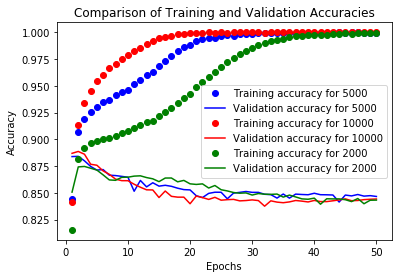

In [8]:
# Compare the accuracies of three training processes
acc5000 = history5000.history['acc']
val_acc5000 = history5000.history['val_acc']
acc10000 = history10000.history['acc']
val_acc10000 = history10000.history['val_acc']
acc2000 = history2000.history['acc']
val_acc2000 = history2000.history['val_acc']

PlotThreeAccuracyComparison(acc5000, val_acc5000, acc10000, val_acc10000, acc2000, val_acc2000, '5000', '10000', '2000')

In [9]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

def PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, lab1 = '1', lab2 = '2', lab3 = '3'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.plot(epochs, loss3, 'go', label='Training loss for ' + lab3)
    plt.plot(epochs, val_loss3, 'g', label='Validation loss for ' + lab3)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

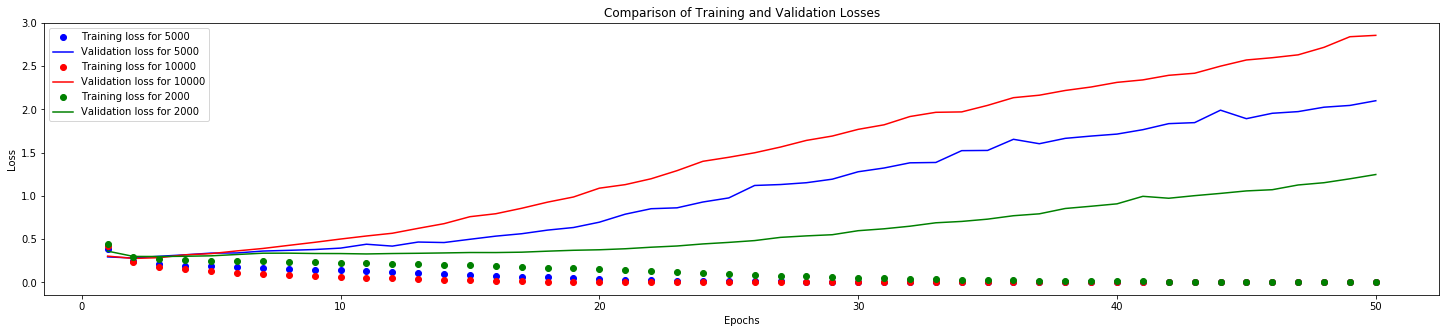

In [10]:
# Compare the losses of three training processes
loss5000 = history5000.history['loss']
val_loss5000 = history5000.history['val_loss']
loss10000 = history10000.history['loss']
val_loss10000 = history10000.history['val_loss']
loss2000 = history2000.history['loss']
val_loss2000 = history2000.history['val_loss']

PlotThreeLossComparison(loss5000, val_loss5000, loss10000, val_loss10000, loss2000, val_loss2000, '5000', '10000', '2000')

In [13]:
argmax1 = np.argmax(val_acc5000)
argmax2 = np.argmax(val_acc10000)
argmax3 = np.argmax(val_acc2000)
print ('Max accuracy for model 1 is: ', val_acc5000[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc10000[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc2000[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.884119987487793 , achieved in the  1 epoch.
Max accuracy for model 2 is:  0.8886799812316895 , achieved in the  1 epoch.
Max accuracy for model 3 is:  0.8746799826622009 , achieved in the  2 epoch.


Pokazuje maksymalne dokładności walidacji osiągnięte podczas szkolenia oraz epokę, w której to nastąpiło.

## Uwagi

Jak widać, dokładność modelu rośnie wolniej dla mniejszej liczby używanych słów, ale utrata walidacji maleje wraz ze zmniejszaniem się liczby najczęściej używanych słów. Możemy więc stwierdzić, że użycie mniejszej liczby najczęściej używanych słów jest skuteczne w tym zadaniu.

Możemy również zauważyć, że proces adaptacji najmniejszego zestawu najczęściej występujących słów zajmuje najwięcej czasu (co widać na wykresie "Accuracy"), ale jest to pozytywna konsekwencja wymuszenia na sieci uczenia się skompresowanej reprezentacji, co skutkuje lepszą generalizacją niż w przypadku modeli, które dopasowują się zbyt szybko! Możemy stwierdzić, że jeśli model dopasowuje się bardzo/zbyt szybko, to najprawdopodobniej będzie się nadmiernie dopasowywał!

Teraz możesz spróbować sprawdzić inne numery najczęściej występujących słów, np. num_top_words=1500 lub 1000 lub 500 i znajdź optymalną liczbę takich słów użytych do budowy tego modelu.

## Walka z nadmiernym dopasowaniem: Zmniejszanie rozmiaru sieci

Jednym z najprostszych sposobów zapobiegania nadmiernemu dopasowaniu jest zmniejszenie rozmiaru modelu, czyli liczby możliwych do nauczenia parametrów (np. W uczeniu głębokim liczba możliwych do nauczenia parametrów w modelu jest często określana jako <b>„pojemność” modelu</b>. Intuicyjnie, model z większą liczbą parametrów będzie miał większą „zdolność do zapamiętywania”, a zatem będzie w stanie łatwo nauczyć się doskonałego słownikowego mapowania między próbkami treningowymi a ich celami/etykietami na zbiorze uczącym, tj. <b>mapowania bez umiejętności uogólnienia</b> - tego nie chcemy!

Na przykład model z 600 000 parametrów binarnych można łatwo stworzyć tak, aby nauczył się klas wszystkich cyfr
Zestaw treningowy MNIST: potrzebowalibyśmy tylko 10 parametrów binarnych dla każdej z 60 000 cyfr. Jednak taki model byłby bezużyteczny do klasyfikowania próbek nowych cyfr. Nie wierzysz, sprawdź! Pamiętaj o tym: modele głębokiego uczenia się zwykle dobrze dopasowują się do danych treningowych, ale prawdziwym wyzwaniem jest uogólnienie, a nie dopasowanie. Kiedy generalizacja jest słaba, model jest bezużyteczny!

Z drugiej strony, jeśli sieć ma ograniczone zasoby zapamiętywania, nie będzie w stanie łatwo nauczyć się pożądanego odwzorowania, a zatem, aby zminimalizować jego stratę (loss), będzie musiała uciekać się do uczenia się skompresowanych reprezentacji, które mają moc predykcyjną w odniesieniu do celu nauki — dokładnie taki typ reprezentacji, jaki nas interesuje! Jednocześnie pamiętaj, że powinieneś używać modeli, które mają wystarczająco dużo parametrów, aby nie były niedopasowane: Twój model nie powinien być ani zagłodzony ani przesycony - czyli szukamy optymalnej liczby zasobów do zapamiętywania. Dlatego musimy znaleźć odpowiedni kompromis między „zbyt dużą pojemnością” a „niewystarczającą pojemnością” (liczbą parametrów modelu) modelu.

Niestety, nie ma magicznej formuły, która pozwoliłaby określić, jaka jest właściwa liczba warstw lub jaki jest odpowiedni rozmiar każdej warstwy. To dobry temat do badań naukowych! Będziesz musiał ocenić szereg różnych architektur (w swoim zestawie walidacyjnym), aby znaleźć odpowiedni rozmiar modelu dla swoich danych. Ogólny plan pracy, mający na celu znalezienie odpowiedniego rozmiaru modelu, polega na rozpoczęciu od stosunkowo niewielkiej liczby warstw i rozmiarów warstw i jego stopniowe zwiększanie, jeśli zmiany przynoszą pozytywne efekty uczenia mierzone przez różne miary błędów i dokładności.

Spróbujmy to zrobić w naszej sieci klasyfikacji recenzji filmów. Porównamy trzy sieci o różnej liczbie jednostek w warstwach ukrytych, używając 2000 najczęściej występujących słów, ponieważ stwierdzono, że zwracają one najniższe straty (loss):

In [14]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history1 = model1.fit(x_train, y_train,
                      epochs=100,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.4626 - acc: 0.8140 - val_loss: 0.3475 - val_acc: 0.8655
Epoch 2/100
25000/25000 [==============================] - 1s 39us/step - loss: 0.3027 - acc: 0.8805 - val_loss: 0.3077 - val_acc: 0.8732
Epoch 3/100
25000/25000 [==============================] - 1s 36us/step - loss: 0.2705 - acc: 0.8924 - val_loss: 0.3006 - val_acc: 0.8750
Epoch 4/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.2589 - acc: 0.8978 - val_loss: 0.3068 - val_acc: 0.8728
Epoch 5/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.2521 - acc: 0.8997 - val_loss: 0.3050 - val_acc: 0.8725
Epoch 6/100
25000/25000 [==============================] - 1s 32us/step - loss: 0.2471 - acc: 0.9017 - val_loss: 0.3138 - val_acc: 0.8696
Epoch 7/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.2442 - acc: 0.9031 - val_loss: 0.3171 - 

In [15]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModel(num_top_words=num_top_words, hl1 = 64, hl2 = 32)

model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

history2 = model2.fit(x_train, y_train,
                      epochs=100,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 43us/step - loss: 0.4051 - acc: 0.8218 - val_loss: 0.3042 - val_acc: 0.8747
Epoch 2/100
25000/25000 [==============================] - 1s 39us/step - loss: 0.2870 - acc: 0.8854 - val_loss: 0.3040 - val_acc: 0.8727
Epoch 3/100
25000/25000 [==============================] - 1s 40us/step - loss: 0.2554 - acc: 0.8948 - val_loss: 0.3091 - val_acc: 0.8703
Epoch 4/100
25000/25000 [==============================] - 1s 40us/step - loss: 0.2290 - acc: 0.9084 - val_loss: 0.3180 - val_acc: 0.8687
Epoch 5/100
25000/25000 [==============================] - 1s 39us/step - loss: 0.1974 - acc: 0.9234 - val_loss: 0.3614 - val_acc: 0.8578
Epoch 6/100
25000/25000 [==============================] - 1s 42us/step - loss: 0.1638 - acc: 0.9376 - val_loss: 0.3322 - val_acc: 0.8691
Epoch 7/100
25000/25000 [==============================] - 1s 41us/step - loss: 0.1267 - acc: 0.9560 - val_loss: 0.3601 - 

In [16]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModel(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history3 = model3.fit(x_train, y_train,
                      epochs=100,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 36us/step - loss: 0.4296 - acc: 0.8102 - val_loss: 0.3310 - val_acc: 0.8679
Epoch 2/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.2961 - acc: 0.8826 - val_loss: 0.3046 - val_acc: 0.8737
Epoch 3/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.2702 - acc: 0.8912 - val_loss: 0.3193 - val_acc: 0.8660
Epoch 4/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.2601 - acc: 0.8966 - val_loss: 0.3039 - val_acc: 0.8732
Epoch 5/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.2524 - acc: 0.8984 - val_loss: 0.3163 - val_acc: 0.8681
Epoch 6/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.2494 - acc: 0.8989 - val_loss: 0.3139 - val_acc: 0.8708
Epoch 7/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.2467 - acc: 0.9016 - val_loss: 0.3187 - 

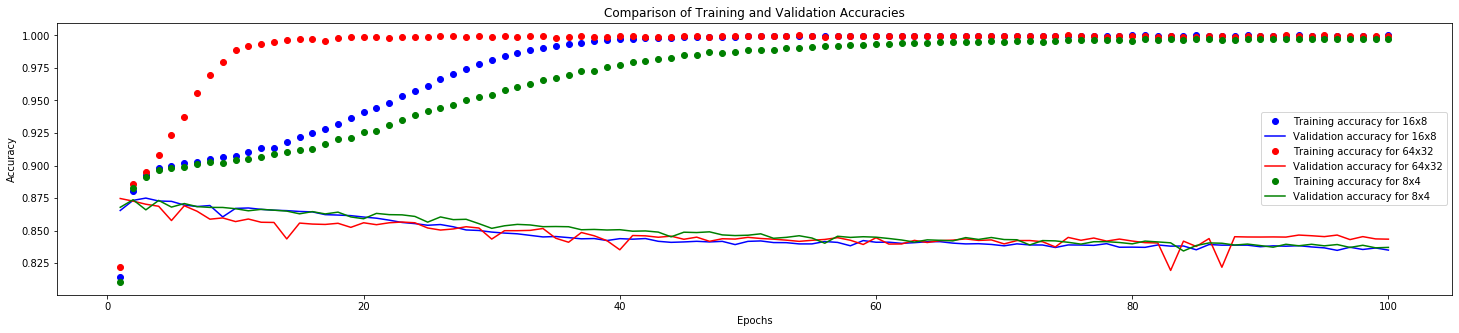

In [17]:
# Compare the accuracies of three training processes
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, '16x8', '64x32', '8x4')

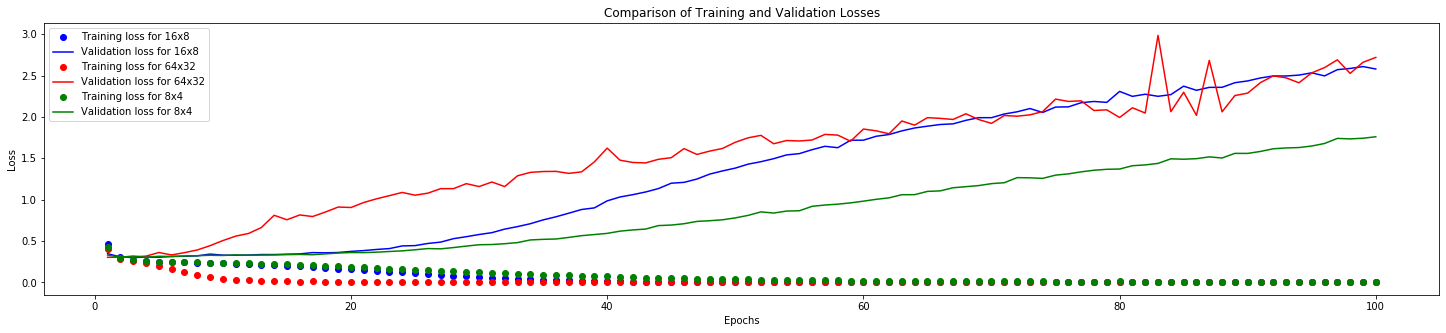

In [18]:
# Compare the losses of three training processes
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, '16x8', '64x32', '8x4')

Ponownie model z najmniejszą liczbą jednostek w warstwach ukrytych osiągnął najmniejszą stratę w porównaniu z pozostałymi dwoma modelami; jednak uczył się najwolniej, ponieważ reprezentacja w małej liczbie jednostek jest trudniejsza niż w przypadku innych sieci. Jak widzieliśmy, powinniśmy trenować ten model nawet dłużej niż przez 100 epok.

Największy model uzyskał zbieżność bardzo szybko i idealnie pasował do prawie wszystkich przykładów uczących, ale jego właściwości uogólniające są najgorsze z porównywanych modeli, ponieważ ma zbyt dużą pojemność zapamiętywania.

In [19]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.875 , achieved in the  2 epoch.
Max accuracy for model 2 is:  0.8746799826622009 , achieved in the  0 epoch.
Max accuracy for model 3 is:  0.8737199902534485 , achieved in the  1 epoch.


Pokazuje maksymalne dokładności walidacji osiągnięte podczas nauki oraz epokę, w której to nastąpiło.

## Walka z nadmiernym dopasowaniem: Dodawanie regularyzacji wagi

Jeśli mamy dwa wyjaśnienia czegoś, to kierując się zasadą brzytwy Ockhama, wyjaśnienie, które najprawdopodobniej będzie poprawne, to wyjaśnienie „najprostsze”, tj. takie, które zawiera najmniej założeń. Dotyczy to również modeli neuronowych: prostsze modele są mniej podatne na nadmierne dopasowanie niż modele złożone.

„Prosty model” to model, w którym rozkład wartości parametrów ma mniejszą entropię. Dlatego powszechnym sposobem łagodzenia nadmiernego dopasowania jest nałożenie ograniczeń na złożoność sieci poprzez wymuszenie, aby jej wagi przyjmowały tylko małe wartości, co sprawia, że rozkład wartości wag jest bardziej „regularny”. Nazywa się to <b>regularyzacją wag</b> i odbywa się poprzez dodanie do funkcji strat sieci _cost_ związanego z posiadaniem dużych wag. Ten _cost_ występuje w dwóch wariantach:
* <b>regularyzacja L1</b>, gdzie dodany _cost_ jest proporcjonalny do _absolute value of the weights coefficients_ (nazywanej „<b>normą L1</b>” wag).
* <b>Regularyzacja L2</b>, gdzie dodany _cost_ jest proporcjonalny do _square of the value of the weights coefficients_ (nazywanych „<b>normą L2</b>” wag). Regularyzacja L2 jest również nazywana <b>_rozpadem wagi (weight decay)_</b> w kontekście sieci neuronowych. Nie daj się zmylić innej nazwie: rozkład masy jest matematycznie dokładnie taki sam jak regularyzacja L2.

W Keras regularyzacja wagi jest dodawana poprzez przekazanie _weight regularizer instances_ do warstw jako argumentów słów kluczowych. Do wyboru mamy trzy opcje:

In [20]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L2 regularization
regularizers.l2(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

Dodajmy regularyzację wagi do naszej najlepszej sieci klasyfikacji recenzji filmów znalezionej w poprzednich krokach i sprawdźmy wszystkie trzy opcje:

In [21]:
def Create3LModelL1(num_top_words, hl1 = 8, hl2 = 4):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def Create3LModelL2(num_top_words, hl1 = 8, hl2 = 4):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def Create3LModelL1L2(num_top_words, hl1 = 8, hl2 = 4):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [22]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModelL1(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyL1 = model1.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 38us/step - loss: 0.6878 - acc: 0.7763 - val_loss: 0.5287 - val_acc: 0.8473
Epoch 2/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4770 - acc: 0.8647 - val_loss: 0.4679 - val_acc: 0.8567
Epoch 3/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.4398 - acc: 0.8714 - val_loss: 0.4468 - val_acc: 0.8606
Epoch 4/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4254 - acc: 0.8736 - val_loss: 0.4308 - val_acc: 0.8669
Epoch 5/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4157 - acc: 0.8740 - val_loss: 0.4262 - val_acc: 0.8664
Epoch 6/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4072 - acc: 0.8773 - val_loss: 0.4191 - val_acc: 0.8699
Epoch 7/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.3993 - acc: 0.8795 - val_loss: 0.4101 - 

In [23]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModelL2(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyL2 = model2.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 45us/step - loss: 0.5096 - acc: 0.8000 - val_loss: 0.3951 - val_acc: 0.8579
Epoch 2/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.3470 - acc: 0.8773 - val_loss: 0.3377 - val_acc: 0.8746
Epoch 3/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.3106 - acc: 0.8888 - val_loss: 0.3291 - val_acc: 0.8766
Epoch 4/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.2977 - acc: 0.8934 - val_loss: 0.3302 - val_acc: 0.8759
Epoch 5/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.2914 - acc: 0.8962 - val_loss: 0.3398 - val_acc: 0.8715
Epoch 6/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.2884 - acc: 0.8976 - val_loss: 0.3492 - val_acc: 0.8682
Epoch 7/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.2856 - acc: 0.8980 - val_loss: 0.3396 - 

In [24]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModelL1L2(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyL3 = model3.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.6956 - acc: 0.7964 - val_loss: 0.5579 - val_acc: 0.8314
Epoch 2/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.5028 - acc: 0.8581 - val_loss: 0.4899 - val_acc: 0.8515
Epoch 3/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.4664 - acc: 0.8625 - val_loss: 0.4669 - val_acc: 0.8573
Epoch 4/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.4494 - acc: 0.8650 - val_loss: 0.4484 - val_acc: 0.8638
Epoch 5/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.4405 - acc: 0.8661 - val_loss: 0.4469 - val_acc: 0.8611
Epoch 6/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.4290 - acc: 0.8707 - val_loss: 0.4321 - val_acc: 0.8672
Epoch 7/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.4221 - acc: 0.8721 - val_loss: 0.4741 - 

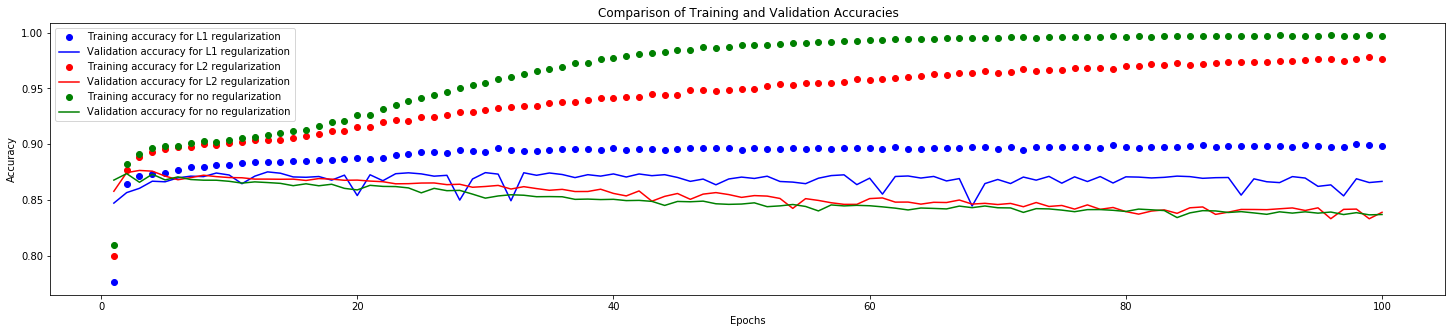

In [25]:
# Compare the accuracies of three training processes
acc1 = historyL1.history['acc']
val_acc1 = historyL1.history['val_acc']
acc2 = historyL2.history['acc']
val_acc2 = historyL2.history['val_acc']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, 'L1 regularization', 'L2 regularization', 'no regularization')

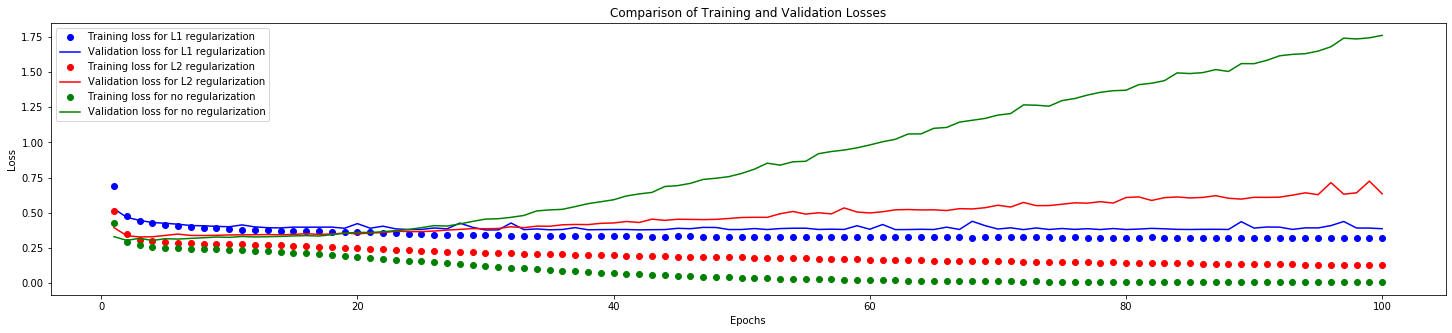

In [26]:
# Compare the losses of three training processes
loss1 = historyL1.history['loss']
val_loss1 = historyL1.history['val_loss']
loss2 = historyL2.history['loss']
val_loss2 = historyL2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, 'L1 regularization', 'L2 regularization', 'no regularization')

In [27]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8752800226211548 , achieved in the  12 epoch.
Max accuracy for model 2 is:  0.8765599727630615 , achieved in the  2 epoch.
Max accuracy for model 3 is:  0.8737199902534485 , achieved in the  1 epoch.


Teraz możemy porównać wyniki uczenia dla modelu bez regularyzacji oraz modeli z regularyzacją L1 lub L2.

Model bez regularyzacji miał mniejsze straty w czasie uczenia, ale dla danych walidacyjnych widzimy, że wyniki uzyskane zarówno dla regularnych modeli L1, jak i L2 są znacznie lepsze niż dla modelu bez regularyzacji!

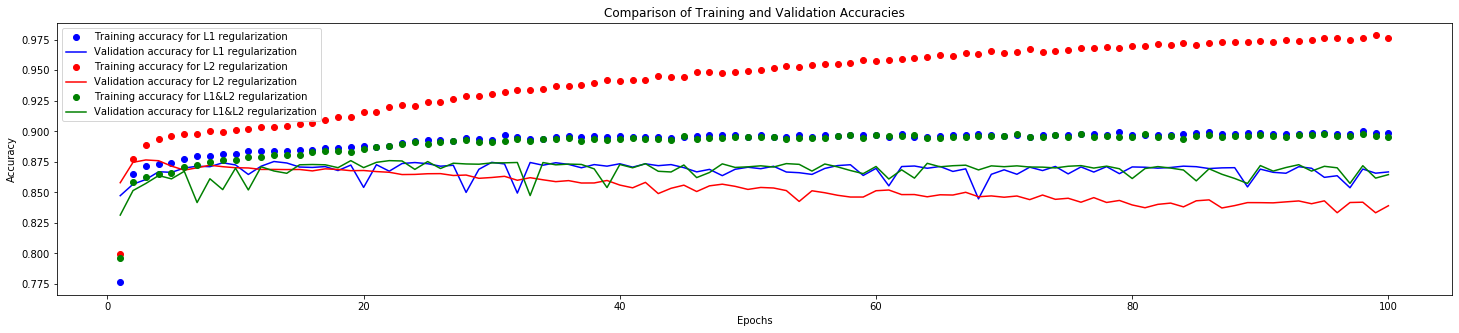

In [28]:
# Compare the accuracies of three training processes
acc1 = historyL1.history['acc']
val_acc1 = historyL1.history['val_acc']
acc2 = historyL2.history['acc']
val_acc2 = historyL2.history['val_acc']
acc3 = historyL3.history['acc']
val_acc3 = historyL3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, 'L1 regularization', 'L2 regularization', 'L1&L2 regularization')

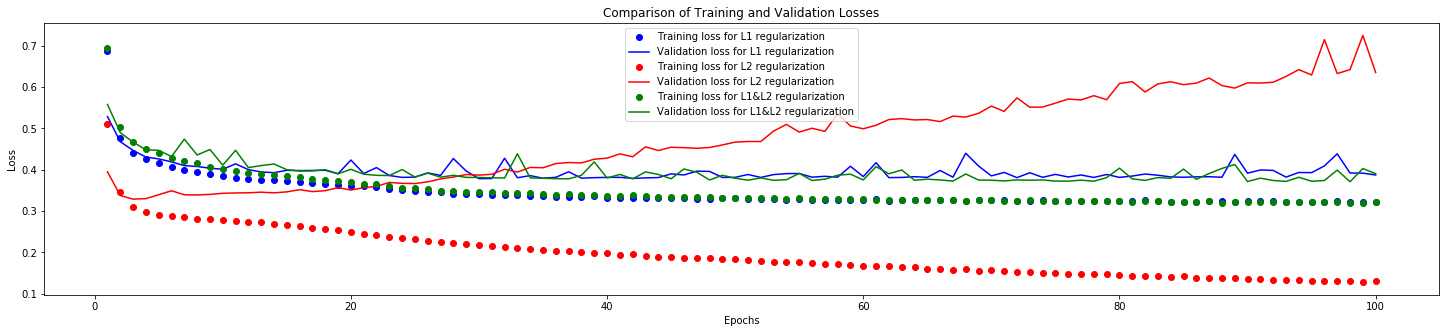

In [29]:
# Compare the losses of three training processes
loss1 = historyL1.history['loss']
val_loss1 = historyL1.history['val_loss']
loss2 = historyL2.history['loss']
val_loss2 = historyL2.history['val_loss']
loss3 = historyL3.history['loss']
val_loss3 = historyL3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, 'L1 regularization', 'L2 regularization', 'L1&L2 regularization')

Porównanie strat dla regularyzacji L1, L2 oraz L1&L2 pokazuje nam, że najmniejszą stratę podczas uczenia uzyskano dla regularyzacji L2, ale jednocześnie największą stratę dla danych walidacyjnych. Nie ma dużej różnicy między stosowaniem regularyzacji L1 i L1&L2, które osiągnęły mniejszą wariancję niż L2.

Mogliśmy zobaczyć, jak kara za regularyzację L2 (`l2(0.001)`) wpłynęła na proces uczenia. `l2(0.001)` oznacza, że każdy współczynnik w macierzy wag warstwy doda `0.001 * weight_coefficient_value` do całkowitej utraty sieci. Zauważ, że ponieważ ta kara jest _dodawana tylko w czasie treningu_, strata dla tej sieci była znacznie większa podczas treningu
niż w czasie testu.

In [30]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8752800226211548 , achieved in the  12 epoch.
Max accuracy for model 2 is:  0.8765599727630615 , achieved in the  2 epoch.
Max accuracy for model 3 is:  0.8759999871253967 , achieved in the  18 epoch.


## Walka z nadmiernym dopasowaniem: dodawanie opuszczania (dropout)

<b>Dropout</b> to jedna z najskuteczniejszych i najczęściej używanych technik regularyzacji sieci neuronowych, opracowana przez Hintona i jego studentów z University of Toronto. Dropout zastosowany do warstwy polega na losowym „wypadnięciu” (dropout) (tj. ustawieniu na zero) pewnej liczby cech wyjściowych warstwy podczas uczenia z określonym prawdopodobieństwem (zwykle między 0,2 a 0,5). W czasie testu żadne jednostki nie są odrzucane, a zamiast tego wartości wyjściowe warstwy są zmniejszane o współczynnik równy wskaźnikowi porzucania, aby zrównoważyć fakt, że więcej jednostek jest aktywnych niż w czasie szkolenia.

Aby to zilustrować, rozważmy macierz Numpy zawierającą dane wyjściowe warstwy `layer_output` o kształcie `(batch_size, features)`. W czasie treningu zerowalibyśmy losowo ułamek wartości w macierzy i skalowalibyśmy o 0,5, aby zachować spójność z podobną siłą stymulacji w czasie testu i pozostawić niezmienioną moc wyjściową w czasie testu:

In [31]:
# At training time:
#layer_output *= np.randint(0, high=2, size=layer_output.shape)
# We are scaling *up* to stay consistent with the stimulations in the test time
#layer_output /= 0.5

Ta technika może wydawać się dziwna i arbitralna. Dlaczego miałoby to pomóc w zmniejszeniu nadmiernego dopasowania? Geoff Hinton powiedział, że zainspirował go między innymi mechanizm zapobiegania oszustwom stosowany przez banki – jak sam mówi: _„Poszedłem do swojego banku. Kasjerzy ciągle się zmieniali i zapytałem jednego z nich dlaczego. Nie wiedziałem, ale często się przemieszczali. Pomyślałem, że tak musi być, ponieważ skuteczne oszukanie banku wymagałoby współpracy między pracownikami. To uświadomiło mi, że losowe usuwanie różnych podzbiorów neuronów na każdym przykładzie zapobiegłoby spiskom, a tym samym zmniejszyć przeuczenie"_.

Podstawową ideą jest to, że wprowadzenie szumu do wartości wyjściowych warstwy może rozbić wzorce zdarzeń, które nie są znaczące (co Hinton nazywa „spiskami”), które sieć zaczęłaby zapamiętywać, gdyby nie było szumu.

W Keras możesz wprowadzić dropout w sieci poprzez warstwę `Dropout`, która jest nakładana na wyjście warstwy tuż przed nią.

In [32]:
#model.add(layers.Dropout(0.5))

Z dropoutem należy korzystać ostrożnie, zwłaszcza w przypadku warstw zawierających niewielką liczbę jednostek, ponieważ zamiana zbyt wielu jednostek może skutkować niedopasowaniem, dlatego w kolejnych eksperymentach podwajamy liczbę jednostek w warstwach ukrytych.

Przeprowadźmy trzy eksperymenty z odrzucaniem różnych prawdopodobieństw `probdrop`, aby sprawdzić, który z nich najbardziej zmniejsza przeuczenie w naszej sieci IMDB:

In [33]:
def Create3LModelL1Dropout(num_top_words, hl1 = 8, hl2 = 4, probdrop=0.5):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dropout(probdrop))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu'))
    model.add(layers.Dropout(probdrop))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [34]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, hl2 = 8, probdrop=0.5)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyD1 = model1.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 51us/step - loss: 0.9174 - acc: 0.6343 - val_loss: 0.6585 - val_acc: 0.8323
Epoch 2/100
25000/25000 [==============================] - 1s 45us/step - loss: 0.6624 - acc: 0.7504 - val_loss: 0.5792 - val_acc: 0.8384
Epoch 3/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.6061 - acc: 0.7906 - val_loss: 0.5148 - val_acc: 0.8526
Epoch 4/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.5862 - acc: 0.8083 - val_loss: 0.5065 - val_acc: 0.8588
Epoch 5/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.5718 - acc: 0.8187 - val_loss: 0.5098 - val_acc: 0.8500
Epoch 6/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.5643 - acc: 0.8245 - val_loss: 0.4964 - val_acc: 0.8549
Epoch 7/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.5637 - acc: 0.8216 - val_loss: 0.4867 - 

In [35]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, hl2 = 8, probdrop=0.25)

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyD2 = model2.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 48us/step - loss: 0.8793 - acc: 0.7232 - val_loss: 0.5980 - val_acc: 0.8320
Epoch 2/100
25000/25000 [==============================] - 1s 38us/step - loss: 0.5954 - acc: 0.8162 - val_loss: 0.5414 - val_acc: 0.8416
Epoch 3/100
25000/25000 [==============================] - 1s 41us/step - loss: 0.5497 - acc: 0.8368 - val_loss: 0.5286 - val_acc: 0.8429
Epoch 4/100
25000/25000 [==============================] - 1s 46us/step - loss: 0.5311 - acc: 0.8452 - val_loss: 0.4950 - val_acc: 0.8584
Epoch 5/100
25000/25000 [==============================] - 1s 43us/step - loss: 0.5166 - acc: 0.8535 - val_loss: 0.4679 - val_acc: 0.8659
Epoch 6/100
25000/25000 [==============================] - 1s 45us/step - loss: 0.5047 - acc: 0.8548 - val_loss: 0.4658 - val_acc: 0.8653
Epoch 7/100
25000/25000 [==============================] - 1s 35us/step - loss: 0.5022 - acc: 0.8573 - val_loss: 0.4655 - 

In [36]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, hl2 = 8, probdrop=0.15)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyD3 = model3.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 43us/step - loss: 0.8473 - acc: 0.7616 - val_loss: 0.5636 - val_acc: 0.8581
Epoch 2/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.5593 - acc: 0.8329 - val_loss: 0.5188 - val_acc: 0.8478
Epoch 3/100
25000/25000 [==============================] - 1s 33us/step - loss: 0.5148 - acc: 0.8497 - val_loss: 0.4754 - val_acc: 0.8648
Epoch 4/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4977 - acc: 0.8572 - val_loss: 0.4723 - val_acc: 0.8612
Epoch 5/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4831 - acc: 0.8604 - val_loss: 0.4775 - val_acc: 0.8587
Epoch 6/100
25000/25000 [==============================] - 1s 34us/step - loss: 0.4739 - acc: 0.8630 - val_loss: 0.4582 - val_acc: 0.8651
Epoch 7/100
25000/25000 [==============================] - 1s 39us/step - loss: 0.4676 - acc: 0.8647 - val_loss: 0.4655 - 

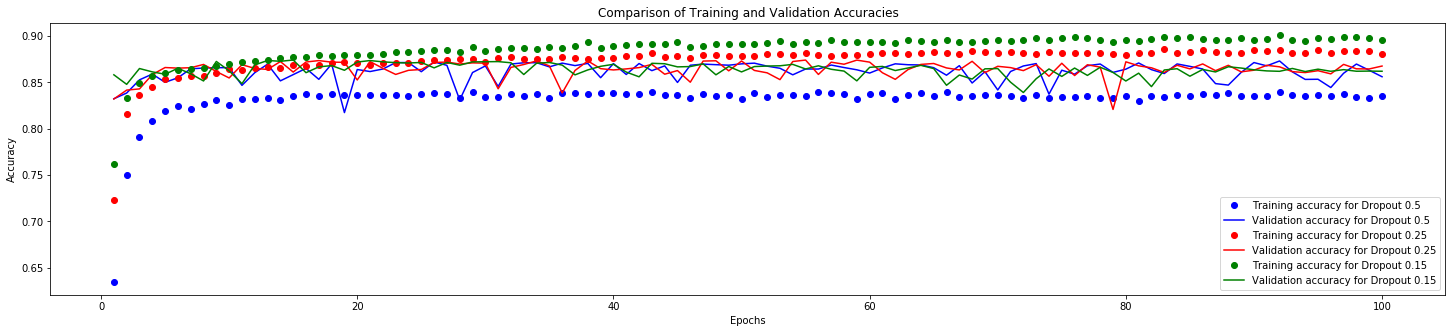

In [37]:
# Compare the accuracies of three training processes
acc1 = historyD1.history['acc']
val_acc1 = historyD1.history['val_acc']
acc2 = historyD2.history['acc']
val_acc2 = historyD2.history['val_acc']
acc3 = historyD3.history['acc']
val_acc3 = historyD3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, 'Dropout 0.5', 'Dropout 0.25', 'Dropout 0.15')

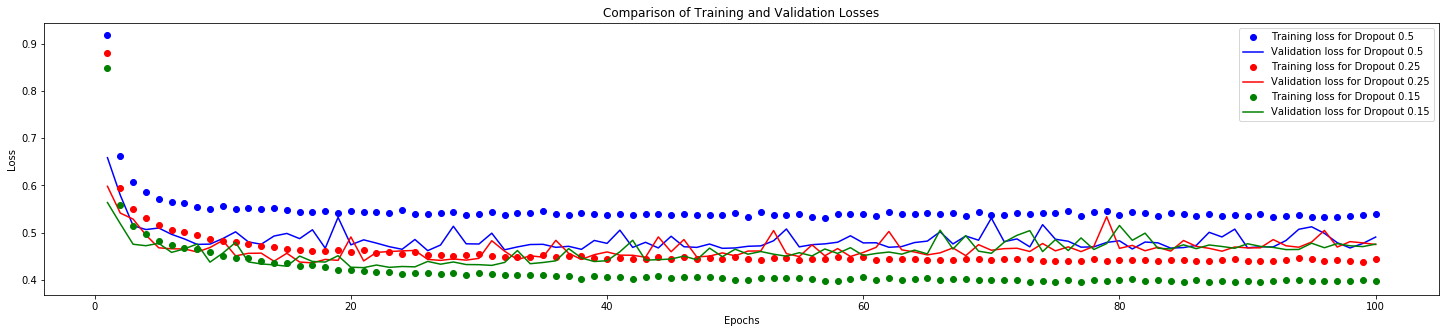

In [38]:
# Compare the losses of three training processes
loss1 = historyD1.history['loss']
val_loss1 = historyD1.history['val_loss']
loss2 = historyD2.history['loss']
val_loss2 = historyD2.history['val_loss']
loss3 = historyD3.history['loss']
val_loss3 = historyD3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, 'Dropout 0.5', 'Dropout 0.25', 'Dropout 0.15')

Nie ma dużej różnicy w dokładności walidacji ani stratach tych modeli; jednak bardziej stabilny jest model z najmniejszym odrzuceniem (dropout).

In [39]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8730000257492065 , achieved in the  91 epoch.
Max accuracy for model 2 is:  0.873960018157959 , achieved in the  54 epoch.
Max accuracy for model 3 is:  0.8740400075912476 , achieved in the  14 epoch.


## Streszczenie

Podsumowując: oto najczęstsze sposoby zapobiegania nadmiernemu dopasowaniu w sieciach neuronowych:
* Uzyskanie większej ilości danych treningowych.
* Zmniejszenie pojemności (parametrów) sieci.
* Dodanie regularyzacji wag.
* Dodanie rezygnacji/odrzucania (dropout).

Teraz zmień niektóre hiperparametry (zielony i czerwony) w powyższych modelach i spróbuj uzyskać ostateczny model, który będzie jeszcze lepszy niż powyższy.

In [41]:
def Create2LModelL1Dropout(num_top_words, hl1 = 32, probdrop=0.2):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dropout(probdrop))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [42]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 8, probdrop=0.2)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history1 = model1.fit(x_train, y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 37us/step - loss: 0.8220 - acc: 0.6655 - val_loss: 0.6093 - val_acc: 0.8352
Epoch 2/100
25000/25000 [==============================] - 1s 32us/step - loss: 0.6060 - acc: 0.7586 - val_loss: 0.5219 - val_acc: 0.8586
Epoch 3/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5545 - acc: 0.7937 - val_loss: 0.4883 - val_acc: 0.8571
Epoch 4/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5377 - acc: 0.8039 - val_loss: 0.4716 - val_acc: 0.8646
Epoch 5/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5216 - acc: 0.8172 - val_loss: 0.4551 - val_acc: 0.8654
Epoch 6/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5081 - acc: 0.8220 - val_loss: 0.4510 - val_acc: 0.8614
Epoch 7/100
25000/25000 [==============================] - 1s 30us/step - loss: 0.5047 - acc: 0.8272 - val_loss: 0.4445 - 

In [43]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, probdrop=0.2)

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history2 = model2.fit(x_train, y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 36us/step - loss: 0.9748 - acc: 0.7067 - val_loss: 0.6475 - val_acc: 0.8420
Epoch 2/100
25000/25000 [==============================] - 1s 30us/step - loss: 0.6237 - acc: 0.7880 - val_loss: 0.5365 - val_acc: 0.8558
Epoch 3/100
25000/25000 [==============================] - 1s 30us/step - loss: 0.5666 - acc: 0.8069 - val_loss: 0.5145 - val_acc: 0.8477
Epoch 4/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5433 - acc: 0.8151 - val_loss: 0.4935 - val_acc: 0.8548
Epoch 5/100
25000/25000 [==============================] - 1s 30us/step - loss: 0.5258 - acc: 0.8228 - val_loss: 0.4772 - val_acc: 0.8584
Epoch 6/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5175 - acc: 0.8246 - val_loss: 0.4877 - val_acc: 0.8478
Epoch 7/100
25000/25000 [==============================] - 1s 29us/step - loss: 0.5051 - acc: 0.8302 - val_loss: 0.4567 - 

In [44]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 32, probdrop=0.2)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history3 = model3.fit(x_train, y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 1s 36us/step - loss: 1.2662 - acc: 0.6918 - val_loss: 0.7170 - val_acc: 0.8242
Epoch 2/100
25000/25000 [==============================] - 1s 30us/step - loss: 0.6755 - acc: 0.7868 - val_loss: 0.6006 - val_acc: 0.8414
Epoch 3/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.6136 - acc: 0.8046 - val_loss: 0.5515 - val_acc: 0.8530
Epoch 4/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5916 - acc: 0.8106 - val_loss: 0.5361 - val_acc: 0.8535
Epoch 5/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5746 - acc: 0.8177 - val_loss: 0.5242 - val_acc: 0.8556
Epoch 6/100
25000/25000 [==============================] - 1s 30us/step - loss: 0.5657 - acc: 0.8209 - val_loss: 0.5055 - val_acc: 0.8598
Epoch 7/100
25000/25000 [==============================] - 1s 31us/step - loss: 0.5532 - acc: 0.8273 - val_loss: 0.4975 - 

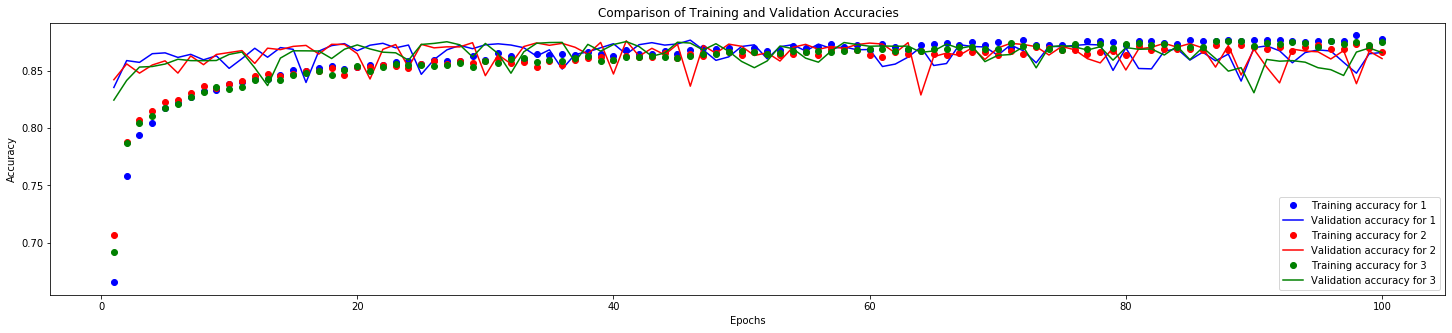

In [45]:
# Compare the accuracies of three training processes
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, '1', '2', '3')

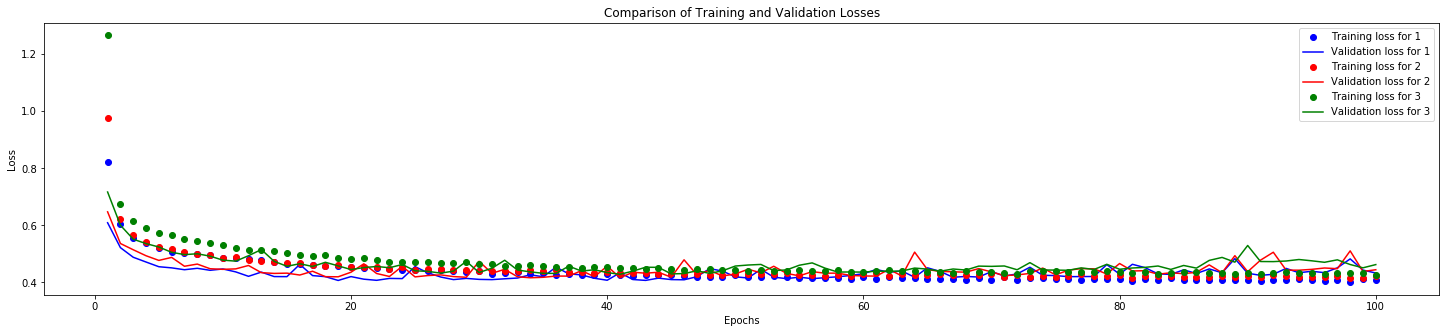

In [46]:
# Compare the losses of three training processes
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, '1', '2', '3')

In [47]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8764399886131287 , achieved in the  45 epoch.
Max accuracy for model 2 is:  0.8758800029754639 , achieved in the  40 epoch.
Max accuracy for model 3 is:  0.8751999735832214 , achieved in the  40 epoch.


Jak widać, udało się pozbyć wariancji modelu, gdyż wykresy kropkowane (dla danych uczących) prawie pokryły się z wykresami kreskowanymi (dla danych walidacyjnych).

## Zadanie:

Proszę spróbować przeprowadzić taki proces regularyzacji modeli dla innego, nietrywialnego zbioru uczącego.